#  Knowledge graph

The general idea of a "knowledge graph" is that more basic algorithms knowledge builds the foundation for more advanced problems. We could build something to this effect by looking at problem tag distributions as user ratings increase. However, this graph may be conflated simply by users "generally getting better" versus "knowledge of A is required for solving B".

#  imports and loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import psycopg2
from collections import defaultdict
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
con = psycopg2.connect(database='codeforces', user='Joy')
cur = con.cursor()

In [3]:
cur.execute("""
SELECT
    table_schema || '.' || table_name
FROM
    information_schema.tables
WHERE
    table_type = 'BASE TABLE'
AND
    table_schema NOT IN ('pg_catalog', 'information_schema');
    """)
rows = cur.fetchall()
for r in rows:
    print r[0].replace("public.", "")

handles
submissions
contests
tags
hacks
user_rating
problem_rating
problem_info


# Load small dataframes in memory

 Read all of the contest df into memory, it's pretty small

In [33]:
df_contests = pd.read_sql("SELECT * FROM contests;", con)

df_contests['endtimeseconds'] = df_contests.starttimeseconds + df_contests.durationseconds
df_contests.set_index(df_contests.contestid, inplace=True)

load smaller dataframes in memory to make processing faster
get a list of all possible tags. Make this into a dictionary for use in collecting the number of each type of problems solved.

In [186]:
problem_rating = pd.read_sql("SELECT * FROM problem_rating;", con)
problem_rating.set_index(['contestid', 'problemid'], inplace=True)
problem_tags = pd.read_sql("SELECT * FROM tags;", con)
problem_tags.set_index(['contestid', 'problemid'], inplace=True)
all_tags = set(problem_tags.tag.values)

# Get intervals and estimate problem accuracy

**General idea:**

* Let a user's contest history be represented by a sequence of numbers $r_i$.
* We are interested in problems solved by this user during all contiguous subsequences of his/her contest history
    * Specifcially, we will count the number of problems solved by user for each tag, as well as the average rating of these problems

**Possible issues:**
* A user's rating might has high volatility, and the number repeatedly goes above or below our cutoffs. Some smoothing is ideally needed, but there is little time for this and the signal might be strong enough

In [272]:
lows = [0,    1200, 1400, 1600, 1900, 2200, 2400]
highs = [1199, 1399, 1599, 1899, 2199, 2399, 2899]

dflist_counts = []
dflist_ratings = []

for lo, hi in zip(lows, highs):
    q = """
    SELECT handle, max(contestid), min(contestid) FROM user_rating
        WHERE
            newrating >= %d
            AND
            newrating <= %d
        GROUP BY handle
    """ % (lo, hi)
    df_intervals = pd.read_sql(q, con)
    df_intervals.columns = ['handle', 'last_cid', 'first_cid']

    starts = df_contests.loc[df_intervals.first_cid, 'starttimeseconds'].values
    ends = df_contests.loc[df_intervals.last_cid, 'endtimeseconds'].values

    tagcountslist = [] 
    tagratinglist = [] 

    cnt = 0
    for hdl, start, end in zip(df_intervals.handle, starts, ends):

        tagcounts = defaultdict(int) # use this dictionary to collect tag counts
        tagrating = defaultdict(int) # use this dictionary to collect sum of problem ratings for each tag

        q = """
            SELECT DISTINCT contestid, problemid FROM submissions
                WHERE
                    starttimeseconds >= %d
                    AND
                    starttimeseconds <= %d
                    AND
                    handle = '%s'
                    AND
                    verdict = 'OK'
        """ % (start, end, hdl)

        cur.execute(q)
        indices = cur.fetchall()

        ratings = problem_rating.loc[indices]
        tags = problem_tags.loc[indices]

        for r, t in zip(ratings.values, tags.values):
            if r[0] is None:
                continue
            tagcounts[ t[0] ] += 1 # increment tag count
            tagrating[ t[0] ] += r[0] # increment rating sum
        
        for t in all_tags:
            if tagcounts[t] > 0:
                tagrating[ t ] /= tagcounts[ t ] # normalize --> mean

        tagcountslist.append(tagcounts)
        tagratinglist.append(tagrating)
        cnt += 1
        if cnt > 5000:
            break
            
    dflist_counts.append(pd.DataFrame.from_dict(tagcountslist))
    dflist_ratings.append(pd.DataFrame.from_dict(tagratinglist))

In [273]:
for i, d in enumerate(dflist_counts):
    d['set'] = los[i]
for i, d in enumerate(dflist_ratings):
    d['set'] = los[i]

In [274]:
df_counts = pd.concat(dflist_counts)
df_ratings= pd.concat(dflist_ratings)
df_ratings.head()
df_counts.head()

,nan,*special,2-sat,binary search,bitmasks,brute force,chinese remainder theorem,combinatorics,constructive algorithms,data structures,...,probabilities,schedules,shortest paths,sortings,string suffix structures,strings,ternary search,trees,two pointers,set
0,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,2,0,0,0,0
1,13.0,0,0,0,0,0,0,0,1,0,...,0,0,0,3,0,4,0,0,0,0
2,4.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [275]:
gset = df_counts_melt.groupby('set')
medians = []
for k, v in gset:
    m = v.groupby('variable').agg('mean')
#    m['set'] = k
    medians.append(m)

medians = pd.concat(medians)

medians['variable'] = medians.index.values

median_ptab = medians.pivot_table(columns='variable', index='set')

In [ ]:
for target in range(1, len(los)):
    test = median_ptab.loc[los[target]] - median_ptab.loc[los[target-1]]
    t = test.sort_values()[-1:-5]

(0, 50)

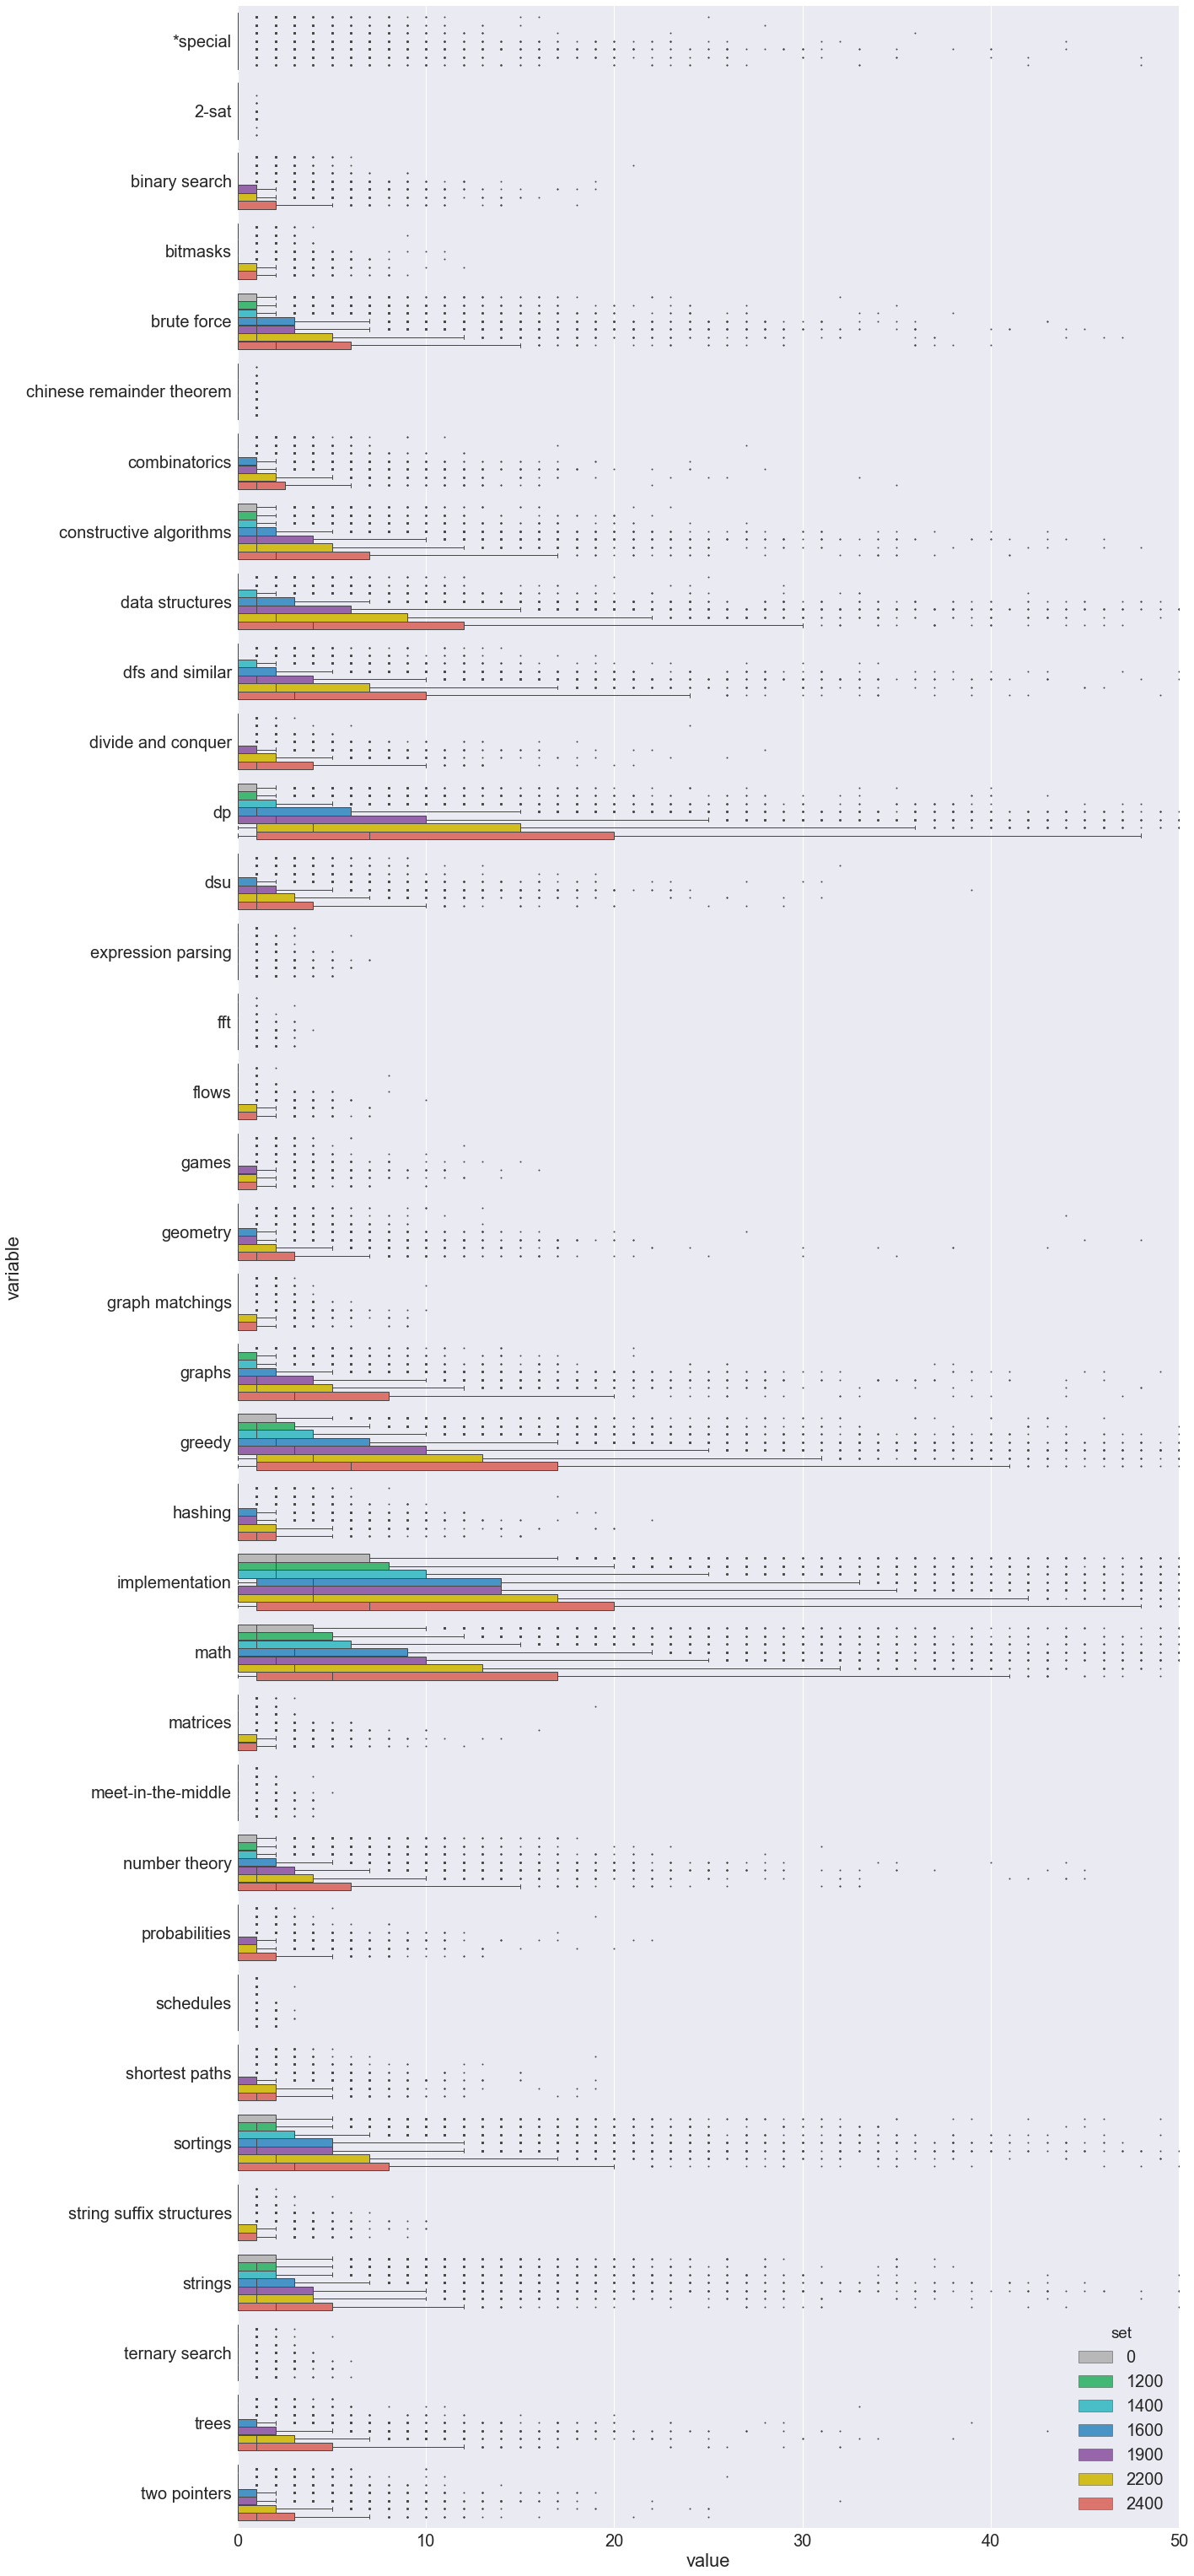

In [276]:
df_counts.fillna(value=0, inplace=True)

sns.set(font_scale=2) 
colors = ["#B8B8B8", "#2ecc71", "#34D0DB", "#3498db", "#9b59b6", "#F0D400", "#ED645A"]
sns.set_palette(sns.color_palette(colors))
plt.rcParams['figure.figsize'] = (20.0, 55.0)

df_counts_melt = df_counts.melt(id_vars='set')
#df_counts_melt = df_counts_melt.loc[~(df_counts_melt.value.values==0)]

sns.boxplot(df_counts_melt.value, df_counts_melt.variable, hue=df_counts_melt.set, linewidth=1, flierprops={'markersize': 2, 'marker': 'o'})
plt.xlim(0, 50)

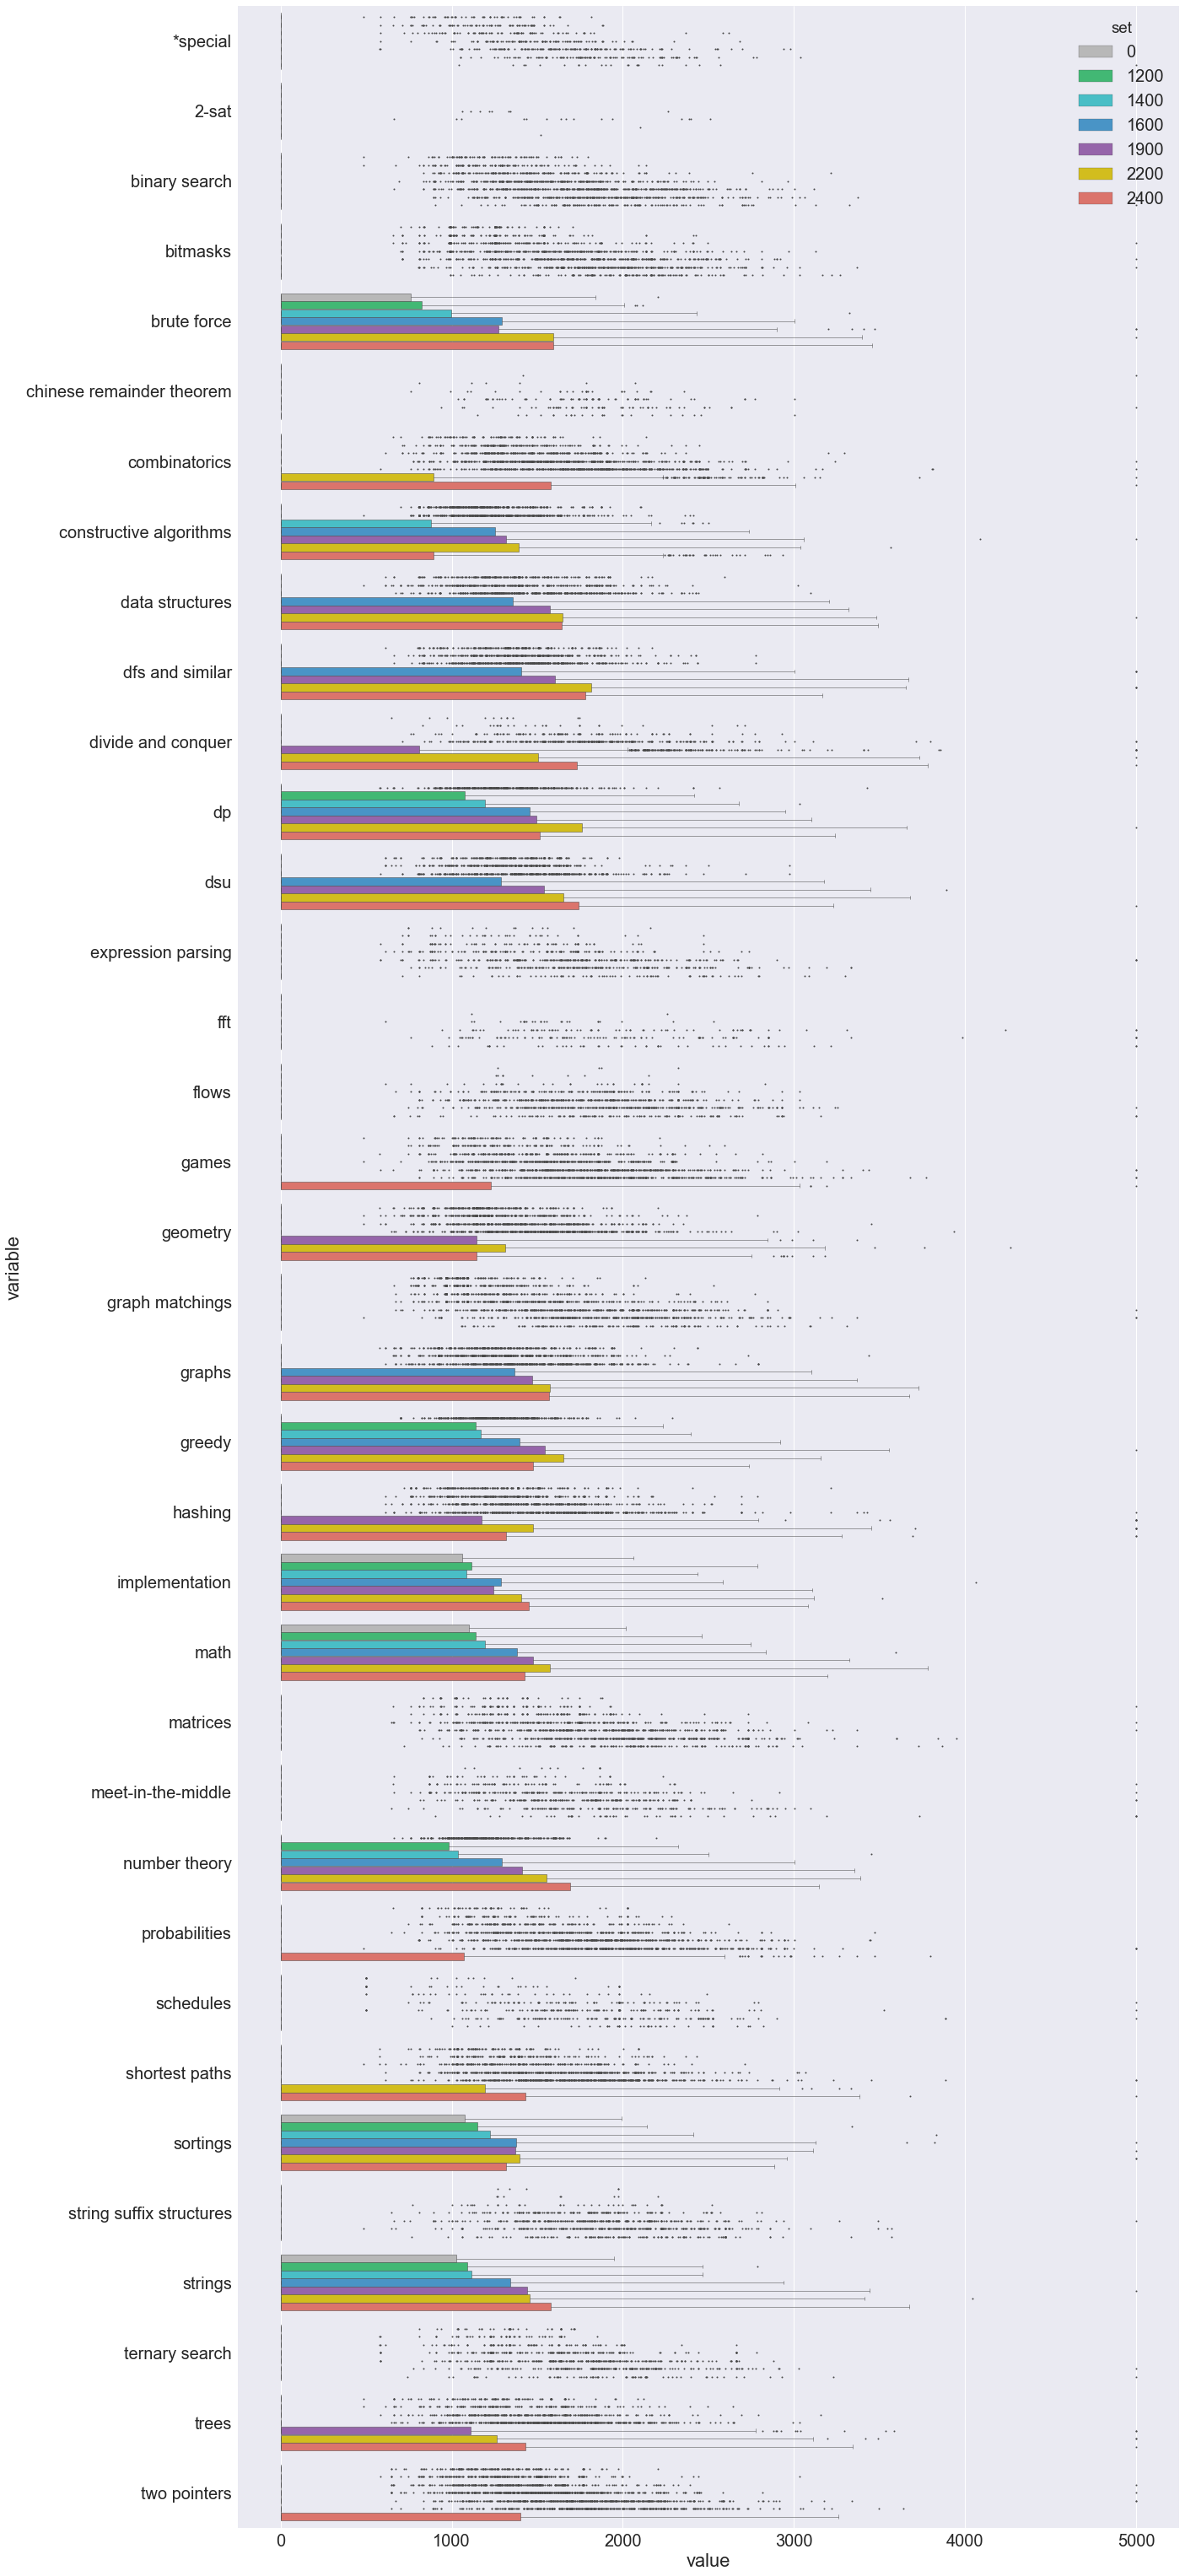

In [222]:
df_ratings.fillna(inplace=True, value=0)

df_ratings_melt = df_ratings.melt(id_vars='set')
sns.boxplot(df_ratings_melt.value, df_ratings_melt.variable, hue=df_ratings_melt.set, linewidth=0.5, flierprops={'markersize': 2, 'marker': 'o'})